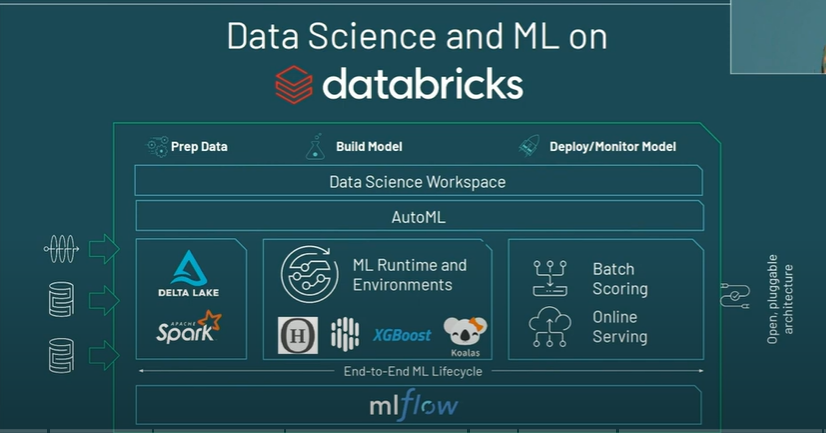

In [2]:
 from PIL import Image
 Image.open("C:/Users/00824732/Desktop/databricks_mlops/databricks_mlops_1.PNG")

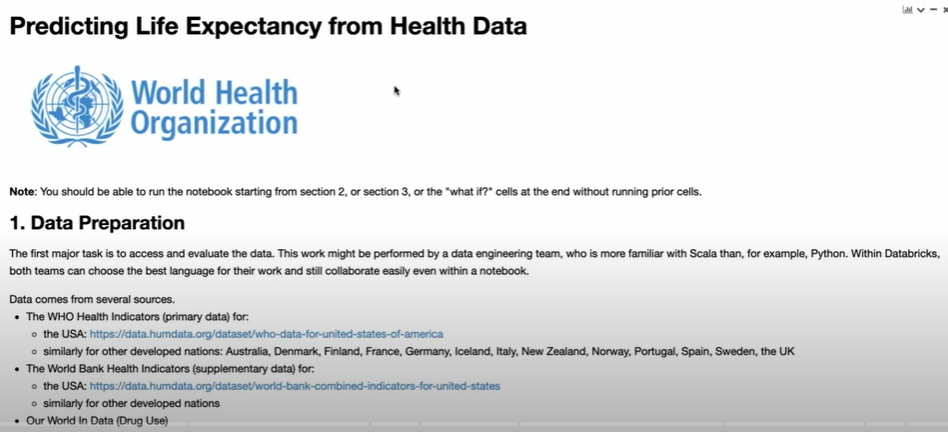

In [2]:
Image.open("C:/Users/00824732/Desktop/databricks_mlops/databricks_mlops_2.PNG")

In [ ]:
%scala
import org.apache.spark.sql.DataFrame

In [ ]:
val path

In [ ]:
def transform(path:String):DataFrame={
    val withComment=spark.read.text(path).filter(!$"value".startwith("#")).as[String]
    spark.read.option("inferSchema",True).option("header",true).csv(withoutComment)
}
var rawHealthIndicators=transformCSV(rawDataPath+"health_indicators/format2").union(transformCSV(rawDataPath+"health_indicators/format1").drop("DATASOURCE (CODE)","DATASOURCE (DISPLAY)","DATASOURCE(URL)"))

display(rawHealthIndicatos)

In [ ]:
## Save the description codes for later use. This contains 109 distinct indicators for the 14 countries

In [ ]:
%fs rm --recursive=true /tmp/knowledgeRepo/ML/gartner_2020/description

In [ ]:
rawHealthIndicators.select().distinct().toDf("Code","Description").write.format("delta").save("/tmp/knowledgeRepo/ML/gartner_2020/descriptions")
display(spark.read.format("delta").load("tmp/KnowledgeRepo/ML/gartner_2020/descriptions").orderBy("Code"))

In [ ]:
import org.apache.spark.sql.functions.{explode,when,udf}
import org.apache.spark.sql.types.FloatType


In [ ]:
rawHealthIndicators=rawHealthIndicators.filter($"GHO (CODE)"!= "WHOSIS_000015")
BrawHealthIndicators=rawHealthIndicators.filter(($"SEX (CODE)".isNull())|| ($"SEC (CODE)"=="BTSX")).drop("SEX (CODE)")

In [ ]:
rawHealthIndicators=rawHealthIndicators.withColumn("Value",when($"Numeric".isNull,$"Display Value").otherwise($"Numeric"))


In [ ]:
val yearsToRangeUDF=udf{(s:String)=>
                         if (s.contains("-")){
                             val Array(start,end)=s.split("-")
                             (start.toInt t end.toInt).toArray
                         }else{
                             Array(s.toInt)
                         }}

In [ ]:
rawHealthIndicators=rawHealthIndicators.withColumn("Year",explode(yearsToRangeUDF($"Year (CODE)")))
rawHealthIndicators=rawHealthIndicators.select($"GHO (CODE)",$"Year",$"Country (CODE)".alias("Country"),$"Value".cast(FloatType))
rawHealthIndicators=rawHealthIndicators.filter("Year>=2000 and Year<=2018")

In [ ]:
val rawHealthIndicators=rawHealthIndicators.groupBy("Country","Year").pivot("GHO").avg("value")
rawHealthIndicators.createOrReplaceTempView("healthIndicators")

In [ ]:
Image.open("ml_ops_3")

In [ ]:
%sql
select year,country from healthIndicators order by Country,year

In [ ]:
%sql
select year,country from healthIndicators where year<=2015

In [ ]:
%scala
var rawIndicators=transformCsv(rawDataPath="indicators")
display(rawIndicators)

In [ ]:
%scala
rawIndicators.select("Indicator code","Indicator Name").distinct().toDF("code","Description").write.format("delta").mode("append").save(" /tmp/KnowledgeRepo/ML/gartner_2020/descriptions").orderBy('Code')
display(spark.read.format("delta").load(path))

In [ ]:
%sql
spark.sql("select * from healthIndicators left outer join indicators using (Country,Year) left outer join rawOverdoeses using(Coutry,Year)").write.format("delta").save(path)

In [ ]:
%sql
CREATE DATABASE IF NOT EXISTS gartner
use gartner
create table if not exists gartner_2020 using DELTA Location '/tmp/KnowledgeRepo/ML/gartner_2020/input'
create table if not exists descriptions using DELTA Location '/tmp/KnowledgeRepo/ML/gartner_2020/description'


In [ ]:
## Analyzing and Modelling

In [ ]:
input_df=spark.read.table("gartner.gartner_2010")
display(input_df.summary())

In [ ]:
## Feature Engineering

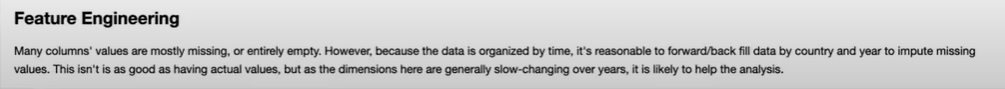

In [5]:
Image.open("C:/Users/00824732/Desktop/databricks_mlops/Feature_Eng.PNG")

In [ ]:
import pandas as pd
input_pd=input_df.OrderBy("Year").toPandas()
input_pd=pd.concat([input_pd['Country'],input_pd.groupby('Country').ffill()],axis=1)
input_pd=pd.concat([input_pd['Country'],input_pd.groupby('Country').ffill()],axis=1)
input_df=spark.createDataFrame(input_pd)

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
selected_indicators=[
    "WHOSIS_OOOOO1"  ## Target Life Expectancy,
    "WHS9_85"  ## Literacy rate among adults aged>=15 years(%),
    "WHS9_96" ## Population living in the urban area,
    "WHS7_156" ## Per capita total expenditure on health at average exchange rate,
    "NY.GDP.PCAP.CD"  ## GP Per capita,
    "BAR.NOED.15UP.ZS" ## Percentage of population age 15+ with no education,
    "OpiodsDeaths"
]

In [ ]:
def hide_current_axis(*args,**kwargs):
    plt.gca().set_visible(False)

In [ ]:
pairplot_pd=input_df
g=sns.pairplot(pairplot_pd,hue="country",list(map(lambda c:f"{c}",selected_indicators))).toPandas()
g.map_upper(hide_current_axis)

In [ ]:
from pyspark.sql import col
countries=sorted(map(lambda r:r['Country'],input_df.select("Country").distinct().collect()))
with_countries_df=input_df
for country in countries:
    with_countries_df=with_countries_df.withColumn(f"Country_{Country}",col("Country")==country)


with_countries_df=with_countries_df.drop("Country")
with_countries_df.write.format("delta").save(path)

In [ ]:
%sql
use gartner
create table if not exists gartner_2020_featuers using delta location 'path'

In [ ]:
## Enabling MLFlow autologging for spark data source

In [ ]:
import mlflow.spark
mlflow.spark.autolog()

In [ ]:
## Modelling

In [ ]:
import databricks.koalas as ks
input_ks=spark.read.table("gartner.gartner_2020_featurized").tokoalas()
input_ks=input_ks[input_ks['Year']<=2016]
input_ks_train=input_ks[input_ks['Year']<=2016]
input_ks_test=input_ks[input_ks['Year']>2014]
x_ks_train=input_ks_train.drop("WHOSIS_000001")
y_ks_train=input_ks_train("WHOSIS_000001")
x_ks_test=input_ks_test.drop("WHOSIS_000001",axis=1)
x_ks_test=input_ks_test.drop("WHOSIS_000001")
y_ks_test=input_ks_test("WHOSIS_000001")

x=input_ks.drop("WHOSIS_000001").to_pandas()
y=  input_ks['WHOSIS_000001'].to_pandas()
x_test=x_ks_test.toPandas()
y_train=y_ks_train.topandas()

y_test=y_ks_test.to_pandas()

In [ ]:
from math import exp
import xgboost as xgb
import mlflow
import numpy as np

In [ ]:
def params_to_xgb(params):
    return {
        'objective': 'reg:squarederror',
        'eval_metrics': 'rmse',
        'max_depth': int(params['max_depth'])
        'learning_rate': exp(params['log_learning_rate']),
        'reg_alpha': exp(params['log_reg_alpha'])
        'reg_lambda': exp(params['log_reg_lambda']),
        'gamma': exp(params['gamma'])
        'min_child_weight': exp(params['log_min_child_weight']),
        'seed': 0
        
    }

In [ ]:
def train_model(params):
    train=xgb.DMatrix(data=x_train,label=y_train)
    test=xgb.DMatrix(data=x_test,label=y_test)
    booster=xgb.train(params=params_to_xgb(params),dtrain=train,num_boost_round=1000,evals=[(test,"test")],early_stopping_rounds=50)
    mlflow.log_params
    return {'status':STATUS_OK,'loss':booster.best_score,'booster':booster_attributes()}

search_space={
    'max_depth': hp.quniform('max_depth'20,60,1),
    'log_learning_rate': hp.quniform('log_learning_rate',-3,0),
    'log_reg_alpha'hp.quniform('log_reg_alpha',-5,-1),
    'log_reg_lambda': hp.quniform('log_reg_lambda',1,8)
    'log_gamma': hp.quniform('log_gamma',-6,-1),
    'log_min_child_weight': hp.quniform('log_min_child_weight',-1,4)
}
spark_trials=SparkTrials(parallelism=12)
best_params=fmin(fn=train_model,space=search_space,algo=)

In [ ]:
import mlflow
import mlflow.xgboost
import matplotlib.pyplot as plt
from mlflow.models.signature import infer_signature
plt.close()

In [ ]:
with mlflow.start_run() as run:
    best_iteration=int(spark_trails.best_trail['result'['booster']['best_iteration']])
    booster=xgb.train(params=params_to_xgb(best_params),dtrain=xbg.DMatrix(data=X,label=y),num_boost_round=best_iteration)
    mlflow.log_param(best_param)
    mlflow.log_param('best_iterations',best_iterations)
    
    mlflow.xgboost.log_model(booster,"xgboost",input_example=x.head(),signature=infer_signature(X,y))
    shap_values=shap.TreeExplainer(booster).shap_values(x,y=y)
    
    shap.summary_plot(shap_values,X,feature_names=display_cols,plot_size=(14,6),max_display=10,show=False)
    
    plg.save
    plt.close()
    mlflow.log_artifact("summary_plot.png")
    best_run=run.info
    

In [ ]:
import time
model_name="gartner_2018"
client=mlflow.tracking.MlflowClient()
try:
    client.create_registered_model(model_name)
except Exception as e:
    pass
model_version=client.create_model_version(model_name,f"{best_run.artifact_uri}/xgboost",best_run.run_id)
time.sleep(5)
client.transition_model_version_stage(model_name,version,stage="staging")

In [ ]:
## Model Interpretation

In [ ]:
client=mlflow.tracking.MlflowClient()
latest_model_detail
client.download_artifacts(latest_model_detail.run_id,"summary_plot.png","/dbfs/FileStore/tmp/KnowledgeRepo/ML/")

In [ ]:
print(x.head(1).to_json(orient='records'))

In [ ]:
## Moving to Production     

In [ ]:
import mlflow
import mlflow.pyfunc
from pyspark.sql.functions import col
from pyspark.sql.types import *
model_udf=mlflow.pyfunc.spark_udf(spark,'models:/gartner_2020/production')
future_input_df=spark.read.table("gartner.gartner_2020_featurized").drp("WHOSIS_000001").filter("Year > 2016")
quoted_cols=list(map(lambda c:f"'{c}'",future_input_df.columns))
with_prediction_df=future_input_df.withColumn("WHOSIS_000001",model_udf(*quoted_cols))


In [ ]:
country_cols=[c for c in with_prediction_df.columns if c.startwith("Country_")]
def unencode_country(*is_country):
    for i in range(len(country_cols)):
        if is_country[i]:
            return country_cols[i][-3:]

unencode_country_udf=udf(unencode_country,StringType())
country_unencoded_df=with_prediction_df.withColumn("Country",unencode_country_udf(*country_cols)).drop(*country_cols)


In [ ]:
## Real time model serving

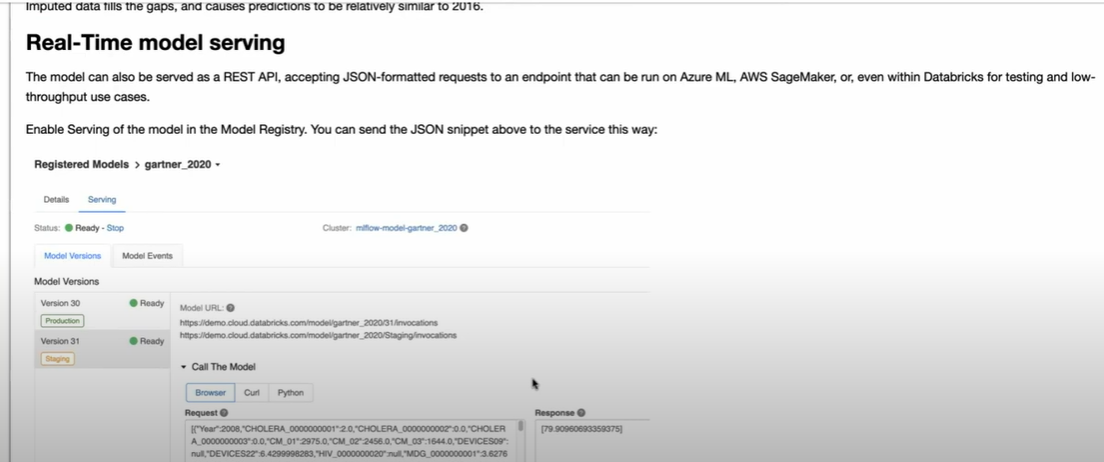

In [3]:
Image.open("C:/Users/00824732/Desktop/databricks_mlops/databricks_realtime_model_servig.PNG")

In [ ]:
input_df=spark.read.table("gartner.gartner_2020")
display(input_df.filter("Year<=2016").select(col('Year'),col("Country"),col("WHOSIS_000001").alias("LifeExpectancy")).union(country_unencoded_df.select(col("Country"),col("WHOSIS_000001").alias("LifeExpectancy"))))

In [ ]:
feature=dbutils.widgets.get("Feature")
from_val=float(dbutils.widgets.get("From"))
to_val=float(dbutils.widgets.get("To"))
count=10
range_val=[to_val-(to_val-from_val)+i / count for i in range(count+1)]

range_year=[2000 +i for i in range(19)]
predictions=np.zeros((len(range_val),len(range_year)))
for i in range(len(range_val)):
    widget_input_pd=future_input_pd.copy()
    widget_input_pd[feature]=range_val[i]
    predictions[i:,]=model.predict(xgb.DMatrix(data=widget_input_pd))

plt.close()
plt.figure(figsize=(14,7))
yticks=[f"{r:.3f}".rstrip('0').rstrip('.') for r in range_val]
display(sns.heatmap(pd.DataFrame(predictions,index=range_val,columns=range_year),cmap='RdYlBu',annot=True,square=True,yticklabels=yticks))

In [ ]:
# https://www.youtube.com/watch?v=5CpaimNhMzs